In [1]:
import graphviz

In [2]:
import os
os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin/"

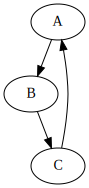

In [3]:
d = graphviz.Digraph()

d.edge("A", "B")
d.edge("B", "C")
d.edge("C", "A")
d

In [4]:
import functools

In [5]:
import inspect

In [6]:
call_stack = []

In [7]:
call_set = set()

In [8]:
def find_call(outputs):
    for c in call_set:
        if c.outputs ==  outputs:
            return c
    raise Exception("No registered call with given outputs.")

In [9]:
class Call:
    """
    Attributes:
        _fun
        _inputs, _outputs, 
        _subcalls
    """    
    def __init__(self, fun, inputs):
        if len(call_stack) > 0:
            call_stack[-1]._subcalls.append(self)
        call_set.add(self)
        
        self._fun = fun
        self._subcalls = []
        self._inputs = inputs
        
    def __str__(self):
        return "Call(inputs = {}, fun = {}, outputs = {})".format(
            self.inputs, self.fun.__name__, self.outputs
        )
    
    @property
    def inputs(self):
        return self._inputs
    @property
    def outputs(self):
        return self._outputs
    @property
    def fun(self):
        return self._fun
        
    def __enter__(self):
        print("*" * len(call_stack) + "entering call of {} with inputs {}".format(self._fun.__name__, self._inputs))
        call_stack.append(self)
        return self
        
    def __exit__(self, *args, **kwargs):
        assert call_stack.pop() == self
        print("*" * len(call_stack) + "exiting call of {} with output {}.".format(self._fun.__name__, self._outputs))
        

In [10]:
def arguments():
        """Returns tuple containing dictionary of calling function's
           named arguments and a list of calling function's unnamed
           positional arguments.
           
           This is from `http://kbyanc.blogspot.com/2007/07/python-aggregating-function-arguments.html`
        """
        from inspect import getargvalues, stack
        posname, kwname, args = getargvalues(stack()[1][0])[-3:]
        posargs = args.pop(posname, [])
        args.update(args.pop(kwname, []))
        return args, posargs


In [11]:
def call_registering(f):
    sig = inspect.signature(f)
    
    @functools.wraps(f)
    def f2(*args, **kwargs):
        assert not args, "Please do not use unnamed arguments when calling `{}`.".format(f.__name__)
        with Call(fun = f, inputs = kwargs) as call:
            ret = f(*args, **kwargs)
            call._outputs = ret
        return ret
    
    return f2

# Usage

In [12]:
@call_registering
def suma(x, y):
    """ Sum the two arguments.
    """
    return x + y

In [13]:
#suma(x = 1, y = 2)

In [14]:
#print(find_call(3))

In [15]:
@call_registering
def factorial(n):
    assert n >= 0
    if n == 0:
        return 1
    return n * factorial(n = n - 1)

In [16]:
factorial(n = 3)

entering call of factorial with inputs {'n': 3}
*entering call of factorial with inputs {'n': 2}
**entering call of factorial with inputs {'n': 1}
***entering call of factorial with inputs {'n': 0}
***exiting call of factorial with output 1.
**exiting call of factorial with output 1.
*exiting call of factorial with output 2.
exiting call of factorial with output 6.


6

In [17]:
import itertools as itt

In [18]:
objs = set.union(
    {c.outputs for c in call_set},
    *[set(c.inputs.values()) for c in call_set]
)

In [19]:
objs

{0, 1, 2, 3, 6}

Call(inputs = {'n': 0}, fun = factorial, outputs = 1)
Call(inputs = {'n': 2}, fun = factorial, outputs = 2)
Call(inputs = {'n': 1}, fun = factorial, outputs = 1)
Call(inputs = {'n': 3}, fun = factorial, outputs = 6)


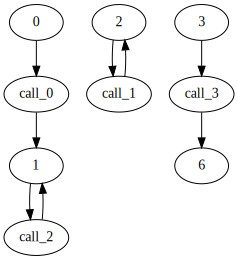

In [20]:
graph = graphviz.Digraph()
for obj in objs:
    graph.node(str(obj))
    
for i, call in enumerate(call_set):
    #graph.node(str(call))
    print(str(call))
    graph.edge("call_{}".format(i), str(call.outputs))
    for inp in call.inputs.values():
        graph.edge(str(inp), "call_{}".format(i))
    
graph

In [21]:
{2, 3,}.union({2})

{2, 3}

In [ ]:
for c in call_set

# Bordel

In [44]:
def g(a, b = 3):
    frame = inspect.currentframe()
    (args, varargs, varkw, values) = inspect.getargvalues(frame)
    print("args: {}, varargs: {}, varkw: {}, values: {}".format(args, varargs, varkw, values))
    
g(1)

args: ['a', 'b'], varargs: None, varkw: None, values: {'a': 1, 'b': 3, 'frame': <frame at 0x000002483A327C18, file '<ipython-input-44-a28bbf247947>', line 4, code g>}


In [46]:
def g(a, b = 3, *args, **kwargs):
    frame = inspect.currentframe()
    (args, varargs, varkw, values) = inspect.getargvalues(frame)
    print("args: {}, varargs: {}, varkw: {}, values: {}".format(args, varargs, varkw, values))
    
g(1, 2, 3, d = 4)

args: ['a', 'b'], varargs: args, varkw: kwargs, values: {'a': 1, 'b': 2, 'args': (3,), 'kwargs': {'d': 4}, 'frame': <frame at 0x000002483A3F8648, file '<ipython-input-46-20b5ad5c3c51>', line 4, code g>}


In [48]:
def g(a, b = 3, *args, **kwargs):
    print(arguments())
    
g(1, 2, 3, d = 4)

({'a': 1, 'b': 2, 'd': 4}, (3,))


In [22]:
from types import SimpleNamespace

In [23]:
a = SimpleNamespace()

In [26]:
a._x = 1
a.y = 2

In [28]:
a.__dict__.items()

dict_items([('_x', 1), ('y', 2)])